Notebook to study the intervals at which datasets are read by CMS users (using crab as that is the source of data popularity this study uses).

The analysis steps are to:
 - Load previously cached popularity information. This consists of dataset name and days on which it was read (and how many files were read)
 - Load previously cached dbs information. This consists of dataset name and dataset size (and other information) for all datasets known to dbs. This is part of the hdfs monitoring information we keep.
 - For datasets read more than once, compute the number of days between reads
 - Histogram these results (Entries vs days between reads)
 - Histogram these results weighted by dataset size.

In [56]:
import gzip
import numpy
myJInput=''
for line in gzip.open('popDaily.txt.gz'):
    myJInput += line

import json    
myJ=json.loads(myJInput)

In [57]:
datasets={}
dates=myJ.keys()

minD=None
maxD=None
i=0
for i,d in enumerate(dates):
    npD=numpy.datetime64(d)
    if minD==None or minD>npD:
        minD=npD
    if maxD==None or maxD<npD:
        maxD=npD
        
#    if i%100==0:
#        print i,d
    records = myJ[d]['DATA']
    for record in records:
        dataset=record['COLLNAME']
        ending=dataset.split('/')[-1]
        if 'AOD' not in ending: continue
        nacc=record["NACC"]
        if dataset not in datasets:
            datasets[dataset]={}
        datasets[dataset][npD]=nacc
        
print "number of datasets in popularity info",len(datasets)
print "first date",minD,"last date",maxD
myJ=None

number of datasets in popularity info 39125
first date 2016-01-01 last date 2018-08-01


In [58]:
import gzip
import csv

dbs_info={}
dbs_columns={}
with gzip.open('dbs.out.gz') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    n=0
    for row in reader:
        if n==0:
            for i,a in enumerate(row[1:]):
                dbs_columns[a]=i
        else:        
            dbs_info[row[0]]=tuple(row[1:])
        n=n+1
print("Done reading dbs info")
#print dbs_columns

Done reading dbs info


In [59]:
#get an array with all the datasets I found in the popularity
datasetList=datasets.keys()

In [60]:
import numpy
allDeltas=numpy.array([])
allSizes=numpy.array([])
col_size=dbs_columns['size']
nKeyError=0
errors=[]
nKeyOk=0
datasetsReadOnce=0
for i in range(len(datasetList)):
    t=numpy.array(datasets[datasetList[i]].keys())
    t.sort()
    if len(t)>1:
        allDeltas=numpy.concatenate((allDeltas, (t[1:]-t[:-1])/numpy.timedelta64(1,'D')), axis=None)
        if datasetList[i] in dbs_info:
            nKeyOk+=1
            allSizes=numpy.concatenate((allSizes, 
                                       (float(dbs_info[datasetList[i]][col_size])/1024./1024./1024.)*numpy.ones(len(t)-1)), 
                                       axis=None)
        else:
            nKeyError+=1
            errors.append(datasetList[i])
            allSizes=numpy.concatenate( (allSizes,numpy.zeros(len(t)-1)), axis=None)
    else: 
        if len(t)==1:
            datasetsReadOnce+=1
print "Missing datasets",nKeyError,"Total datasets",nKeyOk,"Datasets read once",datasetsReadOnce
#uncomment this to get the list of datasets not in the dbs dump
#print errors[0:10]
        

Missing datasets 2499 Total datasets 26623 Datasets read once 10003


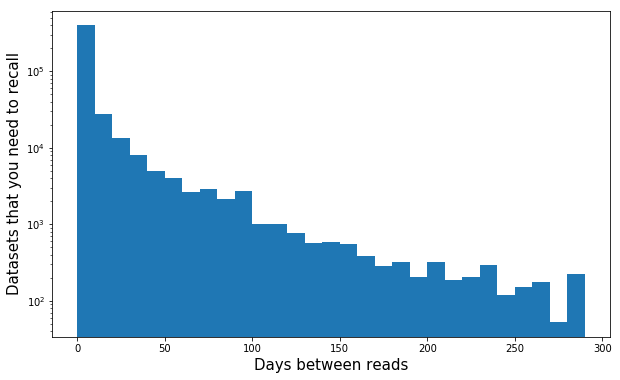

In [61]:
#Plot the number of datasets that you would need to recall given a threshold for 
#the deletion policy
#NOTE: this plot can not be turned into an indication of how many data sets would need to 
#be on disk given that some data sets are read just once (or 0) and thus not included
#From above you see that the number of datasets with just one read is big
#I think we need to include these datasets somehow, but I haven't decided how 
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6
pylab.hist(allDeltas,numpy.arange(0,300,10),log=True)
d=pylab.xlabel('Days between reads',fontsize=15)
d=pylab.ylabel('Datasets that you need to recall',fontsize=15)


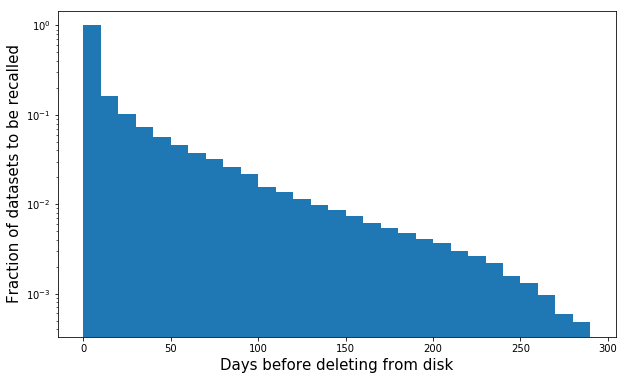

In [62]:
pylab.hist(allDeltas,numpy.arange(0,300,10),log=True,density=True,cumulative=-1)
d=pylab.xlabel('Days before deleting from disk',fontsize=15)
d=pylab.ylabel('Fraction of datasets to be recalled',fontsize=15)

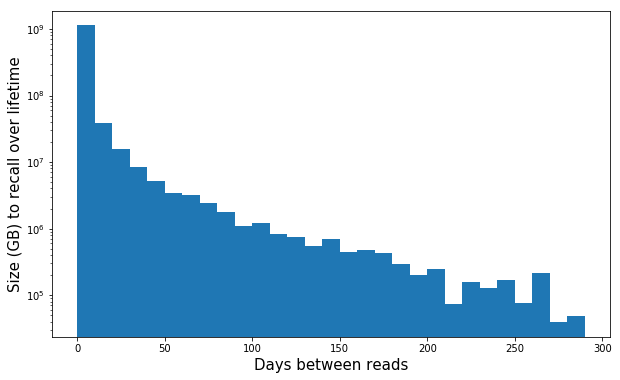

In [63]:
pylab.hist(allDeltas,numpy.arange(0,300,10),weights=allSizes,log=True)
d=pylab.xlabel('Days between reads',fontsize=15)
d=pylab.ylabel('Size (GB) to recall over lifetime',fontsize=15)

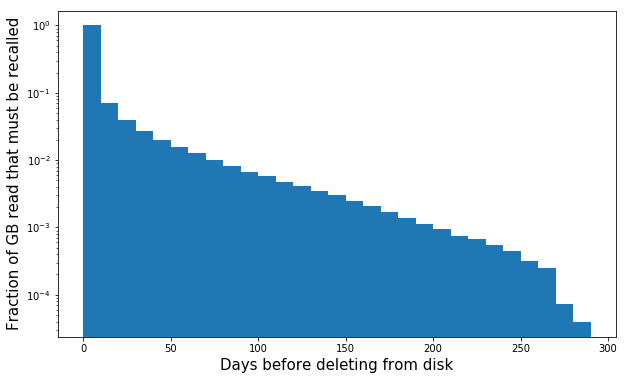

In [64]:
pylab.hist(allDeltas,numpy.arange(0,300,10),weights=allSizes,log=True,density=True,cumulative=-1)
d=pylab.xlabel('Days before deleting from disk',fontsize=15)
d=pylab.ylabel('Fraction of GB read that must be recalled',fontsize=15)